In [1]:
# loading libraries
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model


Using TensorFlow backend.


In [2]:
from osgeo import gdal
import numpy as np


def read_as_array(path,file_name):

    gdal_file=gdal.Open(path+'/'+file_name)

    array=np.zeros((gdal_file.RasterYSize,gdal_file.RasterXSize,gdal_file.RasterCount))
    
    for i in range(gdal_file.RasterCount):

        gdal_file_band=gdal_file.GetRasterBand(i+1)

        array[:,:,i]=gdal_file_band.ReadAsArray()
        
    return(array)     

path='D:/Nafiseh/flood_proposal'

#preflood_image_name,postflood_image_name='0417_clip_2.tif','20190428_coregis_stack_bands.tif'

#preflood_image_name,postflood_image_name='subset_1_of_S1A_IW_GRDH_1SDV_20190408T225218_20190408T225243_Cal_Spk_TC_2.tif','subset_0_of_S1A_IW_GRDH_1SDV_20190425T230019_20190425T230055_Cal_Spk_TC_4_2.tif'
#coh_image_name='S1A_IW_SLC__1SDV_20190408T225217_20190502_20190514_20190526_split_Orb_Stack_esd_coh_deb_flt_ML_TC_Stack.tif'


#preflood_array=read_as_array(path,preflood_image_name)

#postflood_array=read_as_array(path,postflood_image_name)

#postflood_array=np.delete(postflood_array,-1,axis=1)

#stack_image_name='corgistration_intensity_coh_Stack.tif'

stack_image_name='subset_0_of_S1A_IW_GRDH_1SDV_Cal_Spk_TC_Stack.tif'
stack_image_name_2='subset_1_of_S1A_IW_GRDH_1SDV_20190408T225218_20190507T23009_Cal_Spk_TC_Stack_2.tif'

stack_array=read_as_array(path,stack_image_name)
stack_array_2=read_as_array(path,stack_image_name_2)

#coh_co_vv_array_=np.expand_dims(stack_array[:,:,8],axis=2)  #coherency_co; vv
#coh_post_vv_array_=np.expand_dims(stack_array[:,:,10],axis=2) #coherency_post; vv
#preflood_array_=np.concatenate((np.delete(np.repeat(stack_array[:2000,500:2000,2:4],2,axis=2),-1,axis=2),coh_co_vv_array_),axis=2) #VH;VV;VH db
#postflood_array_=np.concatenate((np.delete(np.repeat(stack_array[:2000,500:2000,14:16],2,axis=2),-1,axis=2),coh_post_vv_array_),axis=2)
#preflood_array_=np.concatenate((stack_array[:,:,2:4],coh_co_vv_array_),axis=2)
#postflood_array_=np.concatenate((stack_array[:,:,-3:-1],coh_post_vv_array_),axis=2)

intensity_array_vv=stack_array[500:2000,500:2000,[7,3]]
postflood_array_=np.expand_dims(stack_array_2[500:2000,500:2000,7],axis=2)
label=stack_array[500:2000,500:2000,-1] #flood mask for 25th April

label_test=np.round(stack_array_2[500:2000,500:2000,-1]) 
label_test[label_test<0]=0
label_test[label_test>1]=1 #making label binary (the original labels were not binary maybe because of the co-registration); flood mask for 5th May

print(intensity_array_vv.shape,np.unique(label))

(1500, 1500, 2) [0. 1.]


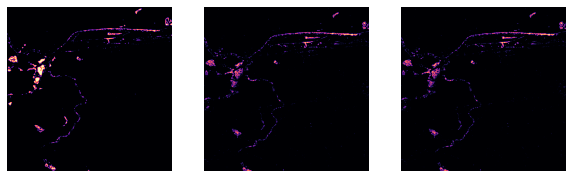

In [3]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(label,cmap='magma') #25th April flood mask

ax[0].axis('off')

ax[1].imshow(label_test,cmap='magma') #5th May flood mask

ax[1].axis('off')

ax[2].imshow(label_test,cmap='magma')

ax[2].axis('off')

plt.show()

# KMeans Clustering

In [ ]:
from sklearn.cluster import KMeans

def vectorize_3d_array(three_d_array):
    
    array=np.zeros((three_d_array.shape[0]*three_d_array.shape[1],three_d_array.shape[2]))
    
    for i in range(three_d_array.shape[2]):
    
        array[:,i]=np.ravel(three_d_array[:,:,i])
        
    return(array)     


preflood_1d_array=vectorize_3d_array(preflood_array_)

#postflood_1d_array=vectorize_3d_array(postflood_array_)

NDWI_pre=np.nan_to_num(np.log(np.divide((preflood_1d_array[:,0]-preflood_1d_array[:,1]),(preflood_1d_array[:,0]+preflood_1d_array[:,1]))))

#NDWI_post=np.nan_to_num(np.divide((postflood_1d_array[:,1]-postflood_1d_array[:,3]),(postflood_1d_array[:,1]+postflood_1d_array[:,3])))

pre_kmeans=KMeans(n_clusters=3,random_state=0).fit(NDWI_pre.reshape(-1,1))

preflood_cluster=pre_kmeans.predict(NDWI_pre.reshape(-1,1))

#post_kmeans=KMeans(n_clusters=3,random_state=0).fit(NDWI_post.reshape(-1,1))

#postflood_cluster=post_kmeans.predict(NDWI_post.reshape(-1,1))

# Loading Clustering Result

In [ ]:
import numpy as np
path='D:/flood_proposal'
#np.save(path+'/postflood_cluster.npy',postflood_cluster)
#np.save(path+'/preflood_cluster.npy',preflood_cluster)
#postflood_cluster=np.load(path+'/postflood_cluster.npy')
preflood_cluster=np.load(path+'/preflood_cluster.npy')

# Visualizing Clustering Result

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(5,5))

plt.imshow(np.reshape(postflood_array_,(postflood_array_.shape[0],postflood_array_.shape[1])),cmap='magma')

plt.axis('off')

plt.show()

In [ ]:
kmeans_preflood_clustering=np.reshape(preflood_cluster,(preflood_array_.shape[0],preflood_array_.shape[1]))
kmeans_postflood_clustering=np.reshape(postflood_cluster,(preflood_array_.shape[0],preflood_array_.shape[1]))

# Train Data Preparation (Part 1)

# Remove This Part

In [ ]:
def prepare_train_data(flood_array,kmeans_clustering):

    sweep=1
    i=1
    j=1

    train_sample=[] 

    label=[]
    
    central_pixel=[]

    while (i<(flood_array.shape[0]-sweep) and j<(flood_array.shape[1]-sweep)):

        #region_labels=kmeans_clustering[i-sweep:i+sweep+1,j-sweep:j+sweep+1]

        region=flood_array[i-sweep:i+sweep+1,j-sweep:j+sweep+1,:]

        while (i<(flood_array.shape[0]-sweep) and j<(flood_array.shape[1]-sweep)):

            region_previous=region

            #region_labels_previous=kmeans_clustering[i,j]
            central_pixel_label_previous=kmeans_clustering[i,j] 


            sweep+=1

            i+=1

            j+=1                                   

            #region_labels=kmeans_clustering[i-sweep:i+sweep+1,j-sweep:j+sweep+1]
            
            #central_pixel_label=kmeans_clustering[i,j]

            region=flood_array[i-sweep:i+sweep+1,j-sweep:j+sweep+1,:]

        if sweep!=1:

            train_sample.append(region_previous)
            label.append(central_pixel_label_previous)
            central_pixel.append((i,j))


        sweep=1 
        i+=1
        j+=1  

    return (train_sample,label,central_pixel)


train_sample,label,_=prepare_train_data(intensity_array_vv,label)
test_sample,label_test,central_pixel=prepare_train_data(postflood_array_,label_test)

In [4]:
def prepare_train_data(flood_array,label):

    row,col=flood_array.shape[0],flood_array.shape[1]
    
    neigh_size=33

    half_size=np.int((neigh_size-1)/2)

    train_sample=[]

    label_new=[]

    for i in range(half_size,row-half_size+1):

        for j in range(half_size,col-half_size+1):

            train_sample.append(flood_array[i-half_size:i+half_size+1,j-half_size:j+half_size+1,:])

            label_new.append(label[i,j])

            #central_pixel.append((i,j))

    return(train_sample,label_new) 

def prepare_test_data(postflood_array,label_test):
    
    neigh_size=33
    
    half_size=np.int((neigh_size-1)/2)
    
    test_sample=[]
    
    label_new=[]
    
    postflood_array_pad=np.pad(postflood_array,((half_size,half_size),(half_size,half_size),(0,0)),'symmetric')
    
    label_test_pad=np.pad(label_test,((half_size,half_size),(half_size,half_size)),'symmetric')
    
    row,col=postflood_array_pad.shape[0],postflood_array_pad.shape[1]
    
    for i in range(half_size,row-half_size+1):
        
        for j in range(half_size,col-half_size+1):
            
            test_sample.append(postflood_array_pad[i-half_size:i+half_size+1,j-half_size:j+half_size+1,:])
            
            label_new.append(label_test_pad[i,j])

            
    return(test_sample,label_new)        

train_sample,label=prepare_train_data(intensity_array_vv,label)            

# Train Data Preparation (Part 2)

In [5]:
from scipy.ndimage import zoom

import random

def resample_data(data_sample,label,mode):

    data_resampled=[]
    
    label_new=[]
    
    patch_size=32
    
    #if label.ndim==2:
       
       #label=np.ravel(label) 

    for k in range(len(data_sample)):
        
        #print(data_sample[k].shape)
        
        if data_sample[k].shape<(patch_size,patch_size):

            data_resampled.append(zoom(data_sample[k],zoom=[patch_size/data_sample[k].shape[0],patch_size/data_sample[k].shape[1],1],order=3))

            label_new.append(label[k])
            
            #continue
        
        elif data_sample[k].shape==(patch_size,patch_size):
            
            data_resampled.append(data_sample[k])
            
            label_new.append(label[k])
            
        elif data_sample[k].shape>(patch_size,patch_size):
            
            for i in range(round(data_sample[k].shape[0]/patch_size)):
                
                for j in range(round(data_sample[k].shape[1]/patch_size)):

                
                    temp=data_sample[k][i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
                
                                
                    if temp.shape<(patch_size,patch_size):

                    
                        data_resampled.append(zoom(temp,zoom=[patch_size/temp.shape[0],patch_size/temp.shape[1],1],order=3))
                        #continue
                        label_new.append(label[k]) 

                    else:
                    
                        data_resampled.append(temp) 
                    
                        label_new.append(label[k])    
                
                   

    data_resampled=np.stack(data_resampled) 

    label_new=np.stack(label_new)

    print(f' {mode} Data Shape: {data_resampled.shape}, {mode} Label Shape: {label_new.shape}')
    
    return (data_resampled,label_new)

train_resampled,label_new=resample_data(train_sample,label,'Train')   

 Train Data Shape: (2157961, 32, 32, 2), Train Label Shape: (2157961,)


# This Section Not Necessary After Changing Train Data Part 1

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#from tensorflow.data import Dataset

#def augment(train_resampled,label_new):
    
    #fliplr=[]
    
    #flipud=[]
    
    #transpose=[]
    
    #label_aug=[]
    
    #for i,l in zip(train_resampled,label_new):
        
            #fliplr.append(np.fliplr(i))
        
            #flipud.append(np.flipud(i))
        
            #transpose.append(np.transpose(i,(1,0,2)))
        
            #label_aug.extend(np.multiply(l,np.ones((3,)))) 
            
    #flip=np.concatenate((np.stack(fliplr),np.stack(flipud)),axis=0) 
    
    #transpose_flip=np.concatenate((flip,np.stack(transpose)),axis=0)
        
    #return(np.concatenate((train_resampled,transpose_flip),axis=0),np.concatenate((label_new,np.stack(label_aug)),axis=0))  
    
#train_resampled_aug,label_aug=augment(train_resampled,label_new)   

def data_augmentation(data,label_new,idx,image_count=150):

        augmented_images=[]
        
        label_aug=[]

        datagen_hflip=ImageDataGenerator(rotation_range=0.1, horizontal_flip=True)
        
        for i in idx:


            it=datagen_hflip.flow(np.expand_dims(data[i],axis=0),batch_size=1)

            for j in range(image_count):
    
                augmented_images.append(np.squeeze(it.next(),axis=0))
        
                label_aug.append(label_new[i])
        
        return(np.stack(augmented_images),np.stack(label_aug)) 
    
positive_idx,negative_idx=np.where(np.array(label_new)==0)[0],np.where(np.array(label_new)==1)[0]

train_resampled_aug_pos,label_aug_pos=data_augmentation(train_resampled,label_new,positive_idx,20)

train_resampled_aug_neg,label_aug_neg=data_augmentation(train_resampled,label_new,negative_idx,2000)

train_resampled_aug=np.concatenate((train_resampled_aug_pos,train_resampled_aug_neg),axis=0)

label_aug=np.concatenate((label_aug_pos,label_aug_neg),axis=0)

In [ ]:
def normalize_data(data_resampled,mode):
    
    for i in range(data_resampled.shape[0]):

            if len(data_resampled.shape)==4:
                
                for j in range(data_resampled.shape[3]):

                    a=data_resampled[i,:,:,j]

                    min_,max_=np.min(np.ravel(data_resampled[i,:,:,j])),np.max(np.ravel(data_resampled[i,:,:,j]))

                    data_resampled[i,:,:,j]=(a-min_)/(max_-min_)
                
            elif len(data_resampled.shape)==2: 
                
                a=data_resampled[i,:]

                min_,max_=np.min(np.ravel(data_resampled[i,:])),np.max(np.ravel(data_resampled[i,:]))

                data_resampled[i,:]=(a-min_)/(max_-min_)

    print(f' {mode} Data Shape: {data_resampled.shape}') 
    
    return(data_resampled)

train_resampled_aug=normalize_data(train_resampled_aug,'Train')

test_resampled=normalize_data(test_resampled, 'Test')

# Splitting data into train and validation

In [6]:
import random

positive_idx,negative_idx=np.where(np.array(label_new)==0)[0],np.where(np.array(label_new)==1)[0]

negative_num,positive_num=len(negative_idx),len(positive_idx)

tr_idx_neg=random.sample(list(negative_idx),round(0.8*negative_num))

tr_idx_pos=random.sample(list(positive_idx),round(0.2*positive_num))

tr_idx=tr_idx_neg+tr_idx_pos #merge

#val_idx=[x for x in list(np.arange(train_resampled.shape[0])) if x not in tr_idx]

val_idx_neg=[x for x in list(negative_idx) if x not in tr_idx_neg]

val_idx_pos=random.sample([y for y in list(positive_idx) if y not in tr_idx_neg],round(0.04*positive_num))

val_idx=val_idx_neg+val_idx_pos

train_resampled_,train_label=train_resampled[tr_idx],label_new[tr_idx]

val_resampled,val_label=train_resampled[val_idx],label_new[val_idx]

print(f' Train Data Shape: {train_resampled_.shape}, Validation Data Shape: {val_resampled.shape}')

print(f' \n Train Label Shape: {train_label.shape}, Validation Label Shape: {val_label.shape}')

 Train Data Shape: (451148, 32, 32, 2), Validation Data Shape: (91533, 32, 32, 2)
 
 Train Label Shape: (451148,), Validation Label Shape: (91533,)


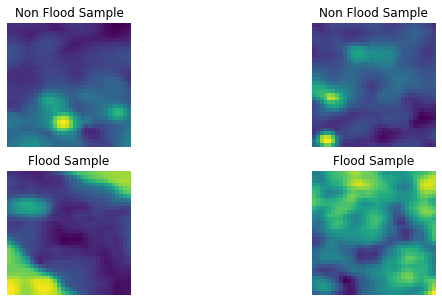

In [7]:
import matplotlib.pyplot as plt

fig,axes=plt.subplots(2,2,figsize=(10,5))

id=tr_idx_pos[:2]+tr_idx_neg[:2]

for i,ax in zip(id,axes.ravel()):
    
    ax.imshow(train_resampled[i,:,:,1])
    
    if label[i]==0:
    
        ax.set_title('Non Flood Sample')
        
        ax.axis('off')
    
    else:
        
        ax.set_title('Flood Sample')
        
        ax.axis('off')
    
plt.show()    

# Embedding Generator Model

## Method 1: Resnet50

In [8]:
from tensorflow.keras.applications import resnet

from tensorflow.keras import applications

from tensorflow.keras import layers,losses,optimizers,metrics,Model

import tensorflow as tf

tf.compat.v1.enable_eager_execution()

patch_size=32

cnn=resnet.ResNet50(weights=None,input_shape=(patch_size,patch_size)+(2,),include_top=False)

flatten=layers.Flatten()(cnn.output)

dense_1=layers.Dense(512,activation='relu')(flatten)

dense_1=layers.BatchNormalization()(dense_1)

dense_2=layers.Dense(256,activation='relu')(dense_1)

dense_2=layers.BatchNormalization()(dense_2)

output=layers.Dense(256)(dense_2)

embedding=Model(cnn.input,output,name='Embedding')

for layer in cnn.layers:
    
    #if 'conv' in layer.name:
        
        #layer.trainable=False
        
    #else:
        
    layer.trainable=True

C:\Users\nghasem2\.conda\envs\Py36\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


## Method 2: Conventional CNN Layers

In [ ]:
embedding_dim=256
patch_size=32

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

embedding=Sequential([Conv2D(32,kernel_size=3,activation='relu',input_shape=(patch_size,patch_size,3)),
                     
                         Conv2D(32,kernel_size=3,activation='relu'),
                            
                         Conv2D(32,kernel_size=3,strides=2,padding='same',activation='relu'),
                      
                         Conv2D(64,kernel_size=3,activation='relu'),
                      
                         GlobalAveragePooling2D(),
                      
                         Dense(embedding_dim) 

])

print(embedding.summary())

### Creating Siamese Network Architecture With Triplets Of Anchor, Positive, and Negative Image Patches as Input

In [9]:
from tensorflow.keras.applications import resnet

from tensorflow.keras import applications

from tensorflow.keras import layers,losses,optimizers,metrics,Model

import tensorflow as tf

from tensorflow.keras.utils import plot_model

patch_size=32

anchor_input=layers.Input(name='anchor',shape=(patch_size,patch_size)+(2,))

positive_input=layers.Input(name='positive',shape=(patch_size,patch_size)+(2,))

negative_input=layers.Input(name='negative',shape=(patch_size,patch_size)+(2,))

embedding_anchor=embedding(anchor_input)
embedding_positive=embedding(positive_input)
embedding_negative=embedding(negative_input)

#output=layers.concatenate([embedding_anchor,embedding_positive,embedding_negative])
output=layers.concatenate([embedding_positive,embedding_negative])

#model=Model([anchor_input,positive_input,negative_input],output)
model=Model([positive_input,negative_input],output)

#plot_model(model,to_file='D:/Nafiseh/flood_proposal/siamese_model_contrastive_loss_intensity_coh.png',show_shapes=True,show_layer_names=True)

# Function Creating Triplets Of Anchor, Positive, and Negative Patches

In [10]:
import random

from keras.preprocessing.image import ImageDataGenerator


def create_batch_data(train_resampled,label,batch_size):
    
        
    def data_augmentation(data,image_count=1):

        augmented_images=[]
        
        patch_size=32

        datagen=ImageDataGenerator(horizontal_flip=True)

        it=datagen.flow(np.expand_dims(data,axis=0),batch_size=1)

        for i in range(image_count):
    
            augmented_images.append(np.squeeze(it.next(),axis=0))
        
        return(np.stack(augmented_images)) 
    
    anchors,positives,negatives=np.zeros((batch_size,patch_size,patch_size,2)),np.zeros((batch_size,patch_size,patch_size,2)),np.zeros((batch_size,patch_size,patch_size,2))

    positive_idx=np.squeeze(np.where(np.array(label)!=1)) #background 
        
    negative_idx=np.squeeze(np.where(np.array(label)==1))
    
    for i in range(batch_size):
        
        index=positive_idx[random.randint(0,len(positive_idx)-1)]

        positive=train_resampled[index]
        
        anchor=data_augmentation(positive)
        
        label_=label[index]
        
        negative=train_resampled[negative_idx[random.randint(0,len(negative_idx)-1)]]
        
        anchors[i],positives[i],negatives[i]=anchor,positive,negative 
    
    return [anchors,positives,negatives]


# Triplet Loss

In [ ]:
import tensorflow as tf

def Triplet_Loss(margin, embedding_dim):
    
    def get_loss(output_true,output_pred):
        
        anchor_output=output_pred[:,:embedding_dim]
        
        positive_output=output_pred[:,embedding_dim:2*embedding_dim]
        
        negative_output=output_pred[:,2*embedding_dim:]
        
        dp=tf.reduce_sum(tf.square(anchor_output-positive_output),axis=1)
        
        dn=tf.reduce_sum(tf.square(anchor_output-negative_output),axis=1)
        
        return tf.maximum(dp-dn+margin,0)
        
    return get_loss    

# Contrastive Loss

In [11]:
def Contrastive_Loss(margin,embedding_dim,tav): #tav:maximum acceptable distance between similar samples
    
    def get_loss(output_true,output_pred):
        
        input1=output_pred[:,:embedding_dim]
        
        input2=output_pred[:,embeding_dim:2*embedding_dim]
        
        d=tf.reduce_sum(tf.square(input1-input2))
        
        return(output_true*tf.maximum(margin-d,0)+(1-output_true)*tf.maximum(d-tav,0))  
    
    return get_loss

# Weighted Double Margin Contrastive Loss (WDMCL)

In [14]:
def Weighted_Double_Margin_Contrastive_Loss(embedding_dim,w1,w2 ,m1=0.9,m2=0.45):
    
    def get_loss(output_true,output_pred):

        
        input1=output_pred[:,:embedding_dim]
    
        input2=output_pred[:,embedding_dim:2*embedding_dim]
        
        d=tf.reduce_sum(tf.square(input1-input2))
        
        return(0.5*((w1*(1-output_true)*(tf.maximum(d-m1,0))**2)+(w2*output_true*(tf.maximum(d-m2,0))**2)))
    
    return(get_loss)       

In [12]:
def Data_Generator(train_resampled,label,batch_size,embedding_dim,mode):
    
    while True:
    
        x=create_batch_data(train_resampled,label,batch_size)
        
        if mode=='triplet':
        
            y=np.zeros((batch_size,3*embedding_dim))
            
        else:
            
            x=x[1:]
            
            y=np.zeros((batch_size,2*embedding_dim))
        
        yield x,y

# Fitting The Siamese Model and Setting Training Parameters

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, SGD


batch_size,embedding_dim, epochs=50, 256, 200

lr_schedule=ExponentialDecay(0.0001,decay_rate=0.8,decay_steps=10000)

#model.compile(loss=Triplet_Loss(margin=0.9, embedding_dim=embedding_dim),optimizer=Adam(learning_rate=lr_schedule))

        
w1=1/(len(train_label[train_label==0])) # weight for unchanged pixels
        
w2=1/(len(train_label[train_label==1])) # weight for changed pixels


model.compile(loss=Weighted_Double_Margin_Contrastive_Loss(embedding_dim,w1,w2,m1=0.9,m2=0.45),optimizer=Adam(learning_rate=lr_schedule))

es=EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)

val_data=create_batch_data(val_resampled,val_label,val_resampled.shape[0])

val_data=val_data[1:] #omitting the anchor images

test_sample,label_test=prepare_test_data(postflood_array_,label_test)
test_resampled,label_test_new=resample_data(test_sample,label_test,'Test')

history=model.fit(Data_Generator(train_resampled_,train_label,batch_size,embedding_dim,'contrastive'),steps_per_epoch=int(train_resampled_.shape[0]/batch_size),epochs=epochs,callbacks=[es],validation_data=(val_data,val_label))

C:\Users\nghasem2\.conda\envs\Py36\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 32, 32, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


 Test Data Shape: (2253001, 32, 32, 1), Test Label Shape: (2253001,)
  ...
    to  
  ['...']
Train for 9022 steps, validate on 91533 samples
Epoch 1/200


C:\Users\nghasem2\.conda\envs\Py36\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 32, 32, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


9022/9022 [==============================] - 14954s 2s/step - loss: 3.8431 - val_loss: 0.0073
Epoch 2/200
9022/9022 [==============================] - 14486s 2s/step - loss: 3.8862e-04 - val_loss: 6.8381e-05
Epoch 3/200
9022/9022 [==============================] - 14260s 2s/step - loss: 3.5766e-06 - val_loss: 1.0008e-06
Epoch 4/200
9022/9022 [==============================] - 14248s 2s/step - loss: 1.0971e-08 - val_loss: 3.8283e-07
Epoch 5/200
9022/9022 [==============================] - 14266s 2s/step - loss: 1.3124e-09 - val_loss: 3.9039e-07
Epoch 6/200
9022/9022 [==============================] - 14349s 2s/step - loss: 1.2680e-10 - val_loss: 7.1280e-07
Epoch 7/200
9022/9022 [==============================] - 14503s 2s/step - loss: 9.9949e-11 - val_loss: 1.6537e-06
Epoch 8/200
9022/9022 [==============================] - 14624s 2s/step - loss: 8.3136e-11 - val_loss: 6.5538e-07
Epoch 9/200
9022/9022 [==============================] - 14578s 2s/step - loss: 8.0196e-12 - val_loss: 8.047

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')

plt.ylabel('Tripplet Loss')

plt.legend(['Train','Validation'])

plt.show()

In [ ]:
model.save('D:/Nafiseh/flood_proposal/siamese_intensity.h5')

In [ ]:
from tensorflow.keras.models import load_model

model=load_model('D:/Nafiseh/flood_proposal/siamese_intensity.h5',compile=False)

In [ ]:
import pickle

with open('D:/Nafiseh/flood_proposal/training history_resnet50_intensity.pckl', 'wb') as hist:
    
    pickle.dump(history.history,hist)

In [ ]:
import pickle

f=open('D:/Nafiseh/flood_proposal/training history_resnet50.pckl','rb')

history=pickle.load(f)

f.close()

# Prediction

In [ ]:
from sklearn.utils import shuffle

from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras import layers,Model

embedding_dim=256

patch_size=32

input_layer=layers.Input(shape=(embedding_dim,))

flatten1=layers.Flatten()(input_layer)

dense1=layers.Dense(256)(flatten1)

LR1=LeakyReLU(alpha=0.1)(dense1)

dense2=layers.Dense(128)(LR1)

LR2=LeakyReLU(alpha=0.1)(dense2)

drop1=layers.Dropout(0.1)(LR2)

dense3=layers.Dense(128)(drop1)

LR3=LeakyReLU(alpha=0.1)(dense3)

drop2=layers.Dropout(0.1)(LR3)

dense4=layers.Dense(64)(drop2)

LR4=LeakyReLU(alpha=0.1)(dense4)

dense5=layers.Dense(32)(LR4)

LR5=LeakyReLU(alpha=0.1)(dense5)

prediction_layer=layers.Dense(2,activation='softmax')(LR5)

model1=Model(input_layer,prediction_layer,name='prediction_model')

#train_data=create_batch_data(train_resampled_,train_label,train_resampled_.shape[0])

##train_label_pos,train_label_neg=train_label[np.where(train_label==0)[0]],train_label[np.where(train_label==1)[0]]

#train_prediction=model.predict(train_data)

#val_prediction=model.predict(val_data)

# Selecting A Subset Of Train And Validation Data (Memory Issue)

In [ ]:
def subset(data,label):

    random.seed(1)

    pos_idx,neg_idx=np.where(np.array(label)==1)[0],np.where(np.array(label)==0)[0]

    pos_idx_subset,neg_idx_subset=random.sample(list(pos_idx),500),random.sample(list(neg_idx),500)

    test_idx_subset=pos_idx_subset+neg_idx_subset

    data_s=[data[i,:] for i in test_idx_subset]

    label_s=[label[j] for j in test_idx_subset]
    
    return(np.stack(data_s),np.stack(label_s))

#train_prediction_s,train_label_s=subset(train_prediction,train_label)

#val_prediction_s,val_label_s=subset(val_prediction,val_label)

# Senario 1: Difference Feature Vectors As Trainin Data to the Network

In [ ]:
train_diff_pos=train_prediction[:,:embedding_dim]-train_prediction[:,embedding_dim:2*embedding_dim]

train_diff_neg=train_prediction[:,:embedding_dim]-train_prediction[:,2*embedding_dim:]

train_diff=np.concatenate((train_diff_pos,train_diff_neg),axis=0)

train_diff_label=np.concatenate((np.zeros((len(train_diff_pos),)),np.ones((len(train_diff_neg),))),axis=0)

val_diff_pos=val_prediction[:,:embedding_dim]-val_prediction[:,embedding_dim:2*embedding_dim]

val_diff_neg=val_prediction[:,:embedding_dim]-val_prediction[:,2*embedding_dim:]

val_diff=np.concatenate((val_diff_pos,val_diff_neg),axis=0)

val_diff_label=np.concatenate((np.zeros((len(val_diff_pos),)),np.ones((len(val_diff_neg),))),axis=0)

# Senario 2: The Original Feature Vectors As Training Data to the Network

In [ ]:
anchor_f=train_prediction[:,:embedding_dim]
pos_f=train_prediction[:,embedding_dim:2*embedding_dim]
neg_f=train_prediction[:,2*embedding_dim:]
train_pos,train_neg=np.concatenate((anchor_f,pos_f),axis=0),neg_f
train_fv=np.concatenate((train_pos,train_neg),axis=0)

pos_num=len(anchor_f)+len(pos_f)
neg_num=len(neg_f)
train_fv_label=np.concatenate((np.zeros((pos_num,)),np.ones((neg_num,))),axis=0)

anchor_f_val,pos_f_val=val_prediction[:,:embedding_dim],val_prediction[:,embedding_dim:2*embedding_dim]
neg_f_val=val_prediction[:,2*embedding_dim:]
val_pos,val_neg=np.concatenate((anchor_f_val,pos_f_val),axis=0),neg_f_val
val_fv=np.concatenate((val_pos,val_neg),axis=0)
pos_num_val=len(anchor_f_val)+len(pos_f_val)
neg_num_val=len(neg_f_val)
val_fv_label=np.concatenate((np.zeros((pos_num_val,)),np.ones((neg_num_val,))),axis=0)

# Instead Of Binary Cross Entropy You can put Pearson Correlation Coefficinet Loss (Ayoubzadeh Paper)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam,SGD,Adadelta

from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers.schedules import ExponentialDecay

#anchor_embedding_train,positive_embedding_train,negative_embedding_train=train_prediction[:,:256],train_prediction[:,256:2*256],train_prediction[:,2*256:3*256]

#embedding_t,label_t=shuffle(np.concatenate((positive_embedding_train,negative_embedding_train),axis=0),np.concatenate((train_label_pos,train_label_neg),axis=0),random_state=2)

lr_Schedule1=ExponentialDecay(0.001,decay_rate=0.8,decay_steps=1000)

es1=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=100,restore_best_weights=True)

model1.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=lr_Schedule1),metrics=['accuracy'])

history1=model1.fit(train_fv,to_categorical(train_fv_label,num_classes=2),batch_size=80, epochs=300,callbacks=[es1],validation_data=(val_fv,to_categorical(val_fv_label,num_classes=2)))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(history1.history['loss'])

plt.plot(history1.history['val_loss'])

plt.xlabel('Epoch')

plt.ylabel('Binary Cross Entropy')

plt.legend(['Train','Validation'])


plt.figure(figsize=(10,5))

plt.plot(history1.history['accuracy'])

plt.plot(history1.history['val_accuracy'])

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend(['Train','Validation'])

plt.show()

In [ ]:
model1.save('D:/Nafiseh/flood_proposal/prediction_layer_model_intensity.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU

model1=load_model('D:/Nafiseh/flood_proposal/prediction_layer_model_intensity.h5',compile=False)

In [ ]:
import pickle

with open('D:/Nafiseh/flood_proposal/prediction_model_history_intensity.pckl','wb') as hist:
    
    pickle.dump(history1.history,hist)

In [ ]:
import pickle

f=open('D:/Nafiseh/flood_proposal/prediction_model_history.pckl','rb')

history1=pickle.load(f)

f.close()

# Training Resnet50 From Scratch

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, SGD


batch_size,embedding_dim, epochs=50, 256, 200
es=EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)

lr_schedule=ExponentialDecay(0.0001,decay_rate=0.8,decay_steps=10000)

model.compile(loss=Triplet_Loss(margin=0.9, embedding_dim=embedding_dim),optimizer=Adam(learning_rate=lr_schedule))

es1=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=100,restore_best_weights=True)

embedding.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=lr_Schedule),metrics=['accuracy'])

history1=embedding.fit(train_resampled_,to_categorical(train_label,num_classes=2),batch_size=80, epochs=300,callbacks=[es1],validation_data=(val_resampled,to_categorical(val_label,num_classes=2)))

In [ ]:
def create_change_map(model,model1,train_data,preflood_resampled,test_resampled,label_test_new,embedding_dim):

    test_label_p=[]

    for i in range(len(test_resampled)):

        #preflood_resampled_expanded=np.expand_dims(preflood_resampled[i],axis=2)
        preflood_resampled_expanded=preflood_resampled
        
        embedding_input=np.expand_dims(np.concatenate((preflood_resampled_expanded[i],test_resampled[i]),axis=2),axis=0)
        
        if i>=len(train_data[0]): #end of the train data
            
            if i%len(train_data[0])==0:
                
               k=0 

            train_anchor=np.expand_dims(train_data[0][k,:,:,:],axis=0)
            
            train_pos=np.expand_dims(train_data[1][k,:,:,:],axis=0)
            
            train_neg=np.expand_dims(train_data[2][k,:,:,:],axis=0)
            
            k+=1
        
        else:
            

            train_anchor=np.expand_dims(train_data[0][i,:,:,:],axis=0)

            train_pos=np.expand_dims(train_data[1][i,:,:,:],axis=0)

            train_neg=np.expand_dims(train_data[2][i,:,:,:],axis=0)

        if label_test_new[i]==1: #change

            embedding=model.predict([train_anchor,train_pos,embedding_input])
            
        elif label_test_new[i]==0: #no change

            embedding=model.predict([train_anchor,embedding_input,train_neg])
        
        #prediction=np.expand_dims(prediction,axis=0)
        
        if label_test_new[i]==1: #change

            test_label_p.append(np.argmax(model1.predict(embedding[:,2*embedding_dim:])))
        
        elif label_test_new[i]==0: #no change
            
            test_label_p.append(np.argmax(model1.predict(embedding[:,embedding_dim:2*embedding_dim])))
            
                            
    return(test_label_p) 

intensity_array_vv_expanded=np.expand_dims(intensity_array_vv[:,:,0],axis=2)

preflood_label=np.zeros((1500,1500))
                            
preflood_array_sample,preflood_label_pad=prepare_test_data(intensity_array_vv_expanded,preflood_label)

preflood_resampled,_=resample_data(preflood_array_sample,preflood_label_pad,'preflood') 

test_label_p=create_change_map(model,model1,train_data,preflood_resampled,test_resampled,label_test_new,embedding_dim)                            

In [ ]:
import numpy as np
#np.save('D:/Nafiseh/flood_proposal/gatineau_change_labels.npy', test_label_p)
test_label_p=np.load('D:/Nafiseh/flood_proposal/gatineau_change_labels.npy')

In [ ]:
def normalize_rgb(image):
    
    for i in range(image.shape[2]):

        image[:,:,i]=np.multiply((image[:,:,i]-np.min(image[:,:,i]))/(np.max(image[:,:,i])-np.min(image[:,:,i])),255)
  
    return(image)    

# Visualizing The Result

In [ ]:
from osgeo import gdal,osr

import matplotlib.pyplot as plt

path='D:/Nafiseh/flood_proposal'

stack_image_name='subset_0_of_S1A_IW_GRDH_1SDV_Cal_Spk_TC_Stack.tif'

Rapid_Eye_Image_name='0428_clip_3.tif'

image_array=read_as_array(path,Rapid_Eye_Image_name)

RGB_image_array=image_array[:,:,[2,1,0]]

ds=gdal.Open(path+'/'+stack_image_name)

ulx,xres,xskew,uly,yskew,yres=ds.GetGeoTransform()

BBOX=[ulx, ulx+xres*1501, uly+yres*1501, uly]

change_map=np.reshape(test_label_p,(1501,1501))

label_test_new_2D=np.reshape(label_test_new,(1501,1501))

orig_map=plt.cm.get_cmap('binary')

reversed_map=orig_map.reversed()

fig,ax=plt.subplots(1,3,figsize=(10,10))

plt.setp(ax, xticks=np.round(np.arange(BBOX[0],BBOX[1],0.05),2), yticks=np.round(np.arange(BBOX[2],BBOX[3],0.05),2))

ax=ax.ravel()

ax[0].imshow(change_map, extent=BBOX, aspect='equal',cmap=reversed_map)

ax[0].set_title('Change Map \n 07/05/2019',fontname='Times New Roman', fontweight='bold', fontsize=14)

ax[1].imshow(label_test_new_2D,extent=BBOX, aspect='equal', cmap=reversed_map)

ax[1].set_title('Ground Truth Mask (thresholding method) \n 07/05/2019',fontname='Times New Roman', fontweight='bold',fontsize=14)

ax[2].imshow(np.uint8(RGB_image_array), extent=BBOX)

ax[2].set_title('Rapid Eye RGB image \n 28/04/2019', fontname='Times New Roman', fontweight='bold',fontsize=14)

fig.tight_layout(pad=3)

plt.savefig('D:/Nafiseh/flood_proposal/tripletloss_2.tif')

plt.show()

# Save Change Map and Ground Truth Map as Geo Tiff

In [ ]:
from osgeo import gdal, osr

def Write_array_as_geotiff(array,raster_name):

    ds=gdal.Open('D:/Nafiseh/flood_proposal/subset_0_of_S1A_IW_GRDH_1SDV_Cal_Spk_TC_Stack.tif')

    ulx,xres,xskew,uly,yskew,yres=ds.GetGeoTransform()

    geotransform=(ulx, xres, xskew, uly, yskew, yres)

    raster=gdal.GetDriverByName('GTiff').Create(raster_name,1501,1501,1,gdal.GDT_Float32)

    raster.SetGeoTransform(geotransform)

    srs=osr.SpatialReference()

    srs.ImportFromEPSG(4326)
    
    raster.GetRasterBand(1).WriteArray(array)
    
    raster.GetRasterBand(1).SetNoDataValue(0)
    
    raster.FlushCache() ##saves to disk
    
    raster=None
    
    ds=None


Write_array_as_geotiff(change_map,'D:/Nafiseh/flood_proposal/CHM_Triplet_Loss.tif')

Write_array_as_geotiff(label_test_new_2D,'D:/Nafiseh/flood_proposal/Change_mask_07052019.tif')

In [ ]:
test_resampled_s,label_test_s=subset(test_resampled,label_test_new)

test_data=create_batch_data(test_resampled_s,label_test_s,test_resampled_s.shape[0])

prediction=model.predict(test_data)

diff_pr_pos=prediction[:,:embedding_dim]-prediction[:,embedding_dim:2*embedding_dim]

diff_pr_neg=prediction[:,:embedding_dim]-prediction[:,2*embedding_dim:]

diff_pr=np.concatenate((diff_pr_pos,diff_pr_neg),axis=0)

#anchor_embedding_test,positive_embedding_test,negative_embedding_test=prediction[:,:256],prediction[:,256:2*256],prediction[:,2*256:3*256]

test_label_p=np.argmax(model1.predict(diff_pr),axis=1)

#dist_pos=np.square(np.expand_dims(np.sum(np.power(diff_pr_pos,2),axis=1),axis=1))
#dist_neg=np.square(np.expand_dims(np.sum(np.power(diff_pr_neg,2),axis=1),axis=1))

#diff_power=np.concatenate((dist_pos,dist_neg),axis=1)

#test_label_p2=np.argmin(diff_power,axis=1)

In [ ]:
test_resampled_s,label_test_s=subset(test_resampled,label_test_new)

test_data=create_batch_data(test_resampled_s,label_test_s,test_resampled_s.shape[0])

prediction=model.predict(test_data)

pr_anchor,pr_pos,pr_neg=prediction[:,:embedding_dim],prediction[:,embedding_dim:2*embedding_dim],prediction[:,2*embedding_dim:]

pr=np.concatenate((pr_anchor,pr_pos,pr_neg),axis=0)

test_label_p=np.argmax(model1.predict(pr),axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

import seaborn as sns

plt.figure(figsize=(5,5))

sns.heatmap(confusion_matrix(label_test_new,test_label_p),annot=True,fmt='d')

plt.savefig('D:/Nafiseh/flood_proposal/confusion_matrix_triplet_loss.tif')

text_file=open('D:/Nafiseh/flood_proposal/classification_report_triplet_loss.txt','a')

print(classification_report(test_label_p,label_test_new),file=text_file)

text_file.close()

In [ ]:
from numpy.linalg import norm
from numpy import dot

def cosine_similarity(vec1,vec2):
    
    return(dot(vec1,vec2)/(norm(vec1)*norm(vec2)))



cosine_sim=np.zeros((prediction.shape[0],2))


for i in range(prediction.shape[0]):
    
    #print('Cosine Similarity between anchor and positive sample number'+str(i)+':', cosine_similarity(anchor_embedding_test[i,:],positive_embedding_test[i,:])) 
      
    #print('Cosine similarity between anchor and negative sample number'+str(i)+':', cosine_similarity(anchor_embedding_test[i,:],negative_embedding_test[i,:]))  
    
    cosine_sim[i,0]=cosine_similarity(anchor_embedding_test[i,:],positive_embedding_test[i,:])
    
    cosine_sim[i,1]=cosine_similarity(anchor_embedding_test[i,:],negative_embedding_test[i,:])
    
predicted_label=np.argmax(cosine_sim,axis=1)  

# Creating Change Map

In [ ]:
test_label_2d_array=postflood_array[300:2000,500:2000,-1]

change_map=np.zeros((test_label_2d_array.shape))

for p,l,id in zip(central_pixel,predicted_label,range(len(test_sample))):
    
    sweep=np.int(np.ceil(test_sample[id].shape[0]/2))-1

    
    if (p[0]+sweep<change_map.shape[0] and p[1]+sweep<change_map.shape[1]):

        change_map[p[0]-sweep:p[0]+sweep+1,p[1]-sweep:p[1]+sweep+1]=np.multiply(l,np.ones((2*sweep+1,2*sweep+1)))
    
    elif (p[0]+sweep<change_map.shape[0] and p[1]+sweep>=change_map.shape[1]):
        
        temp=change_map[p[0]-sweep:p[0]+sweep+1,p[1]-sweep:]
        
        shape=temp.shape
        
        change_map[p[0]-sweep:p[0]+sweep+1,p[1]-sweep:]=np.multiply(l,np.ones((2*sweep+1,shape[1])))
        
    elif (p[0]+sweep>=change_map.shape[0] and p[1]+sweep<change_map.shape[1]): 
        
        temp=change_map[p[0]-sweep:,p[1]-sweep:p[1]+sweep+1]
        
        shape=temp.shape
        
        change_map[p[0]-sweep:,p[1]-sweep:p[1]+sweep+1]=np.multiply(l,np.ones((shape[0],2*sweep+1)))
        
    elif (p[0]+sweep>=change_map.shape[0] and p[1]+sweep>=change_map.shape[1]): 
        
        temp=change_map[p[0]-sweep:,p[1]-sweep:]
        
        shape=temp.shape
        
        change_map[p[0]-sweep:,p[1]-sweep:]=np.multiply(l,np.ones((shape[0],shape[1])))

In [ ]:
def create_patches(array):
    
    patch=[]
    
    pad_width_x_before,pad_width_x_after=8,8
    
    pad_width_y_before,pad_width_y_after=8,8
    
    array=np.pad(array,((pad_width_y_before,pad_width_y_after),(pad_width_x_before,pad_width_x_after),(0,0)),mode='symmetric')
    
    for i in range(pad_width_y_before,array.shape[0]-pad_width_y_after):
        
        for j in range(pad_width_x_before,array.shape[1]-pad_width_x_after):
            
            patch.append(array[i-pad_width_y_before:i+pad_width_y_after,j-pad_width_x_before:j+pad_width_y_after,:])
            
    return(np.stack(patch))  

patches=create_patches(postflood_array_)

postflood_array_s1=label_test

postflood_data=create_batch_data(patches,np.ravel(postflood_array_s1),patches.shape[0])

In [ ]:
postflood_embedding_pr=normalize_data(model.predict(postflood_data),'Test')

change_map=np.reshape(np.argmax(model1.predict(postflood_embedding_pr),axis=1),(1481,1370))